In [1]:
############################################################################
##
## Copyright (C) 2021 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

# Preprocess Transaction Dataset using cuDF

In this notebook we walk-though how to accelerate data preprocessing for turning Tabular Transaction data into DGL Heterograph consists of cards and merchants as nodes and transactions as edges using NVIDIA GPUs and cuDF library. In the next notebook we will see how we can train a GNN in DGL for Link Prediction on this transaction graph.

## About the Transaction Dataset

In the Tabformer Credit Card Fraud Transaction Dataset we have data for:

*  **~24 million transactions** 
* for 2000 unique users spanning years 1990-2020 
* with each user having multiple credit cards spanning 1-9 unique cards, avg is 3 cards per user
* There are total 6,139 unique credit cards 
* 100,343 unique merchants 
* 109 unique MCCs
* 27,321 unique zip codes
* 13,429 unique cities (includes US cities and foreign cities)
* 223 unique values for Merchant State (171 foreign countries + 52 US States and Territories)

Here we show first few rows of the dataset.

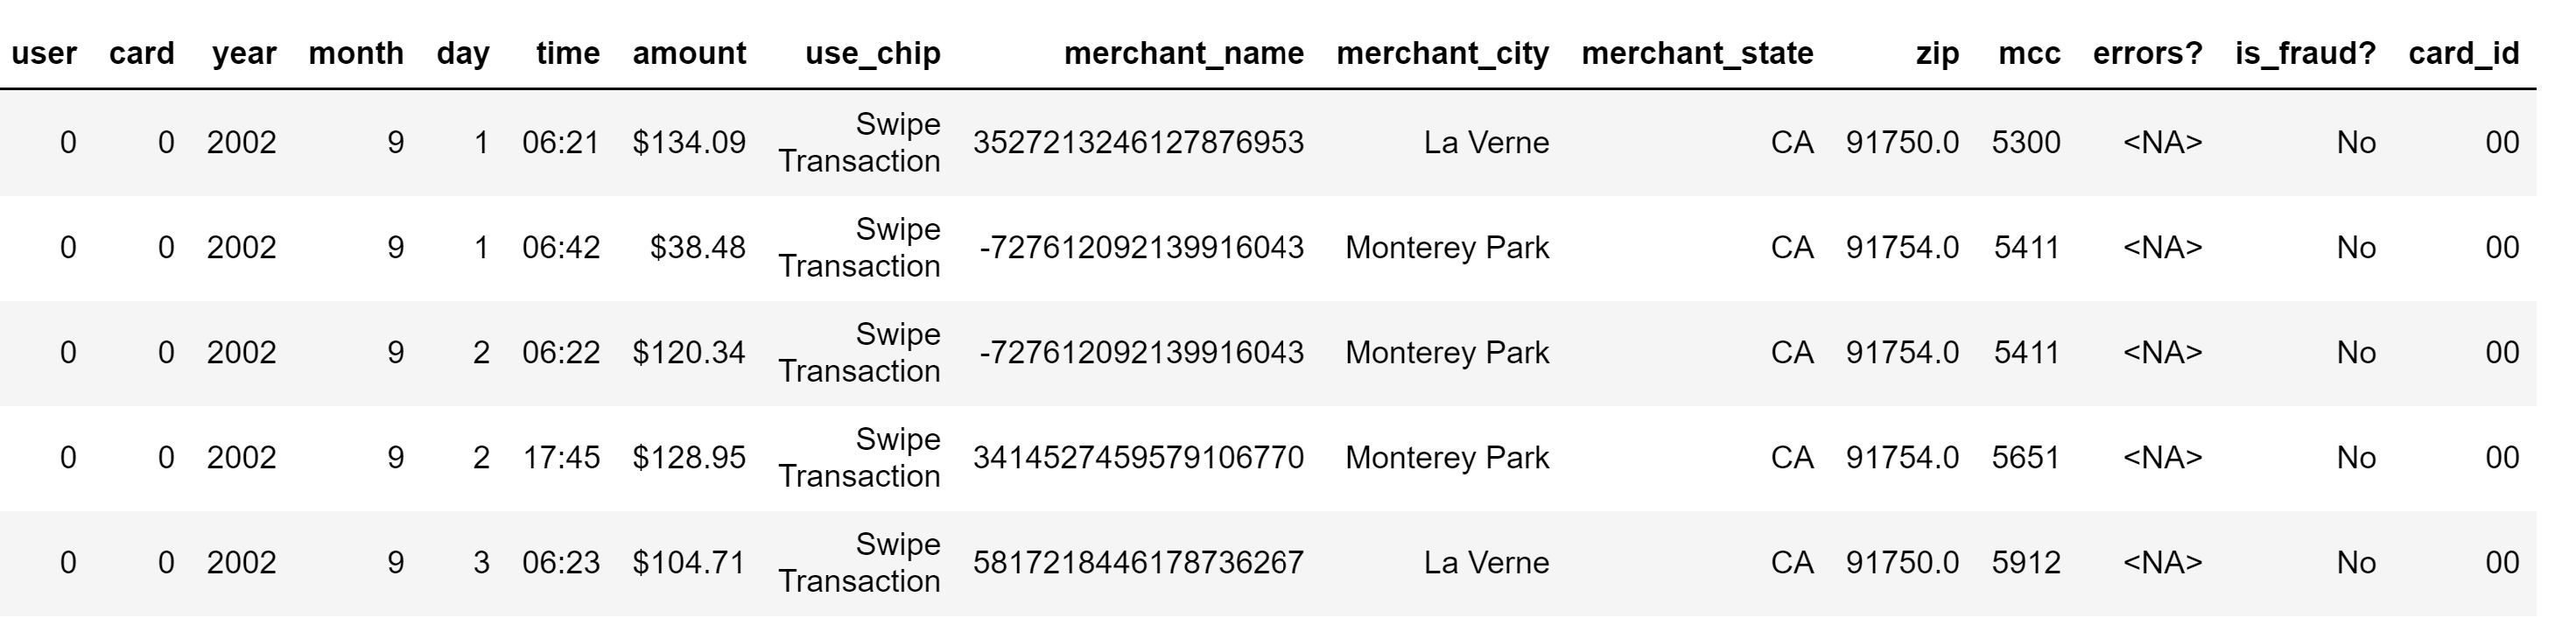

Now we will show how to turn tabular data like that into a Heterogeneous Card-Merchant Transaction graph in DGL like this:
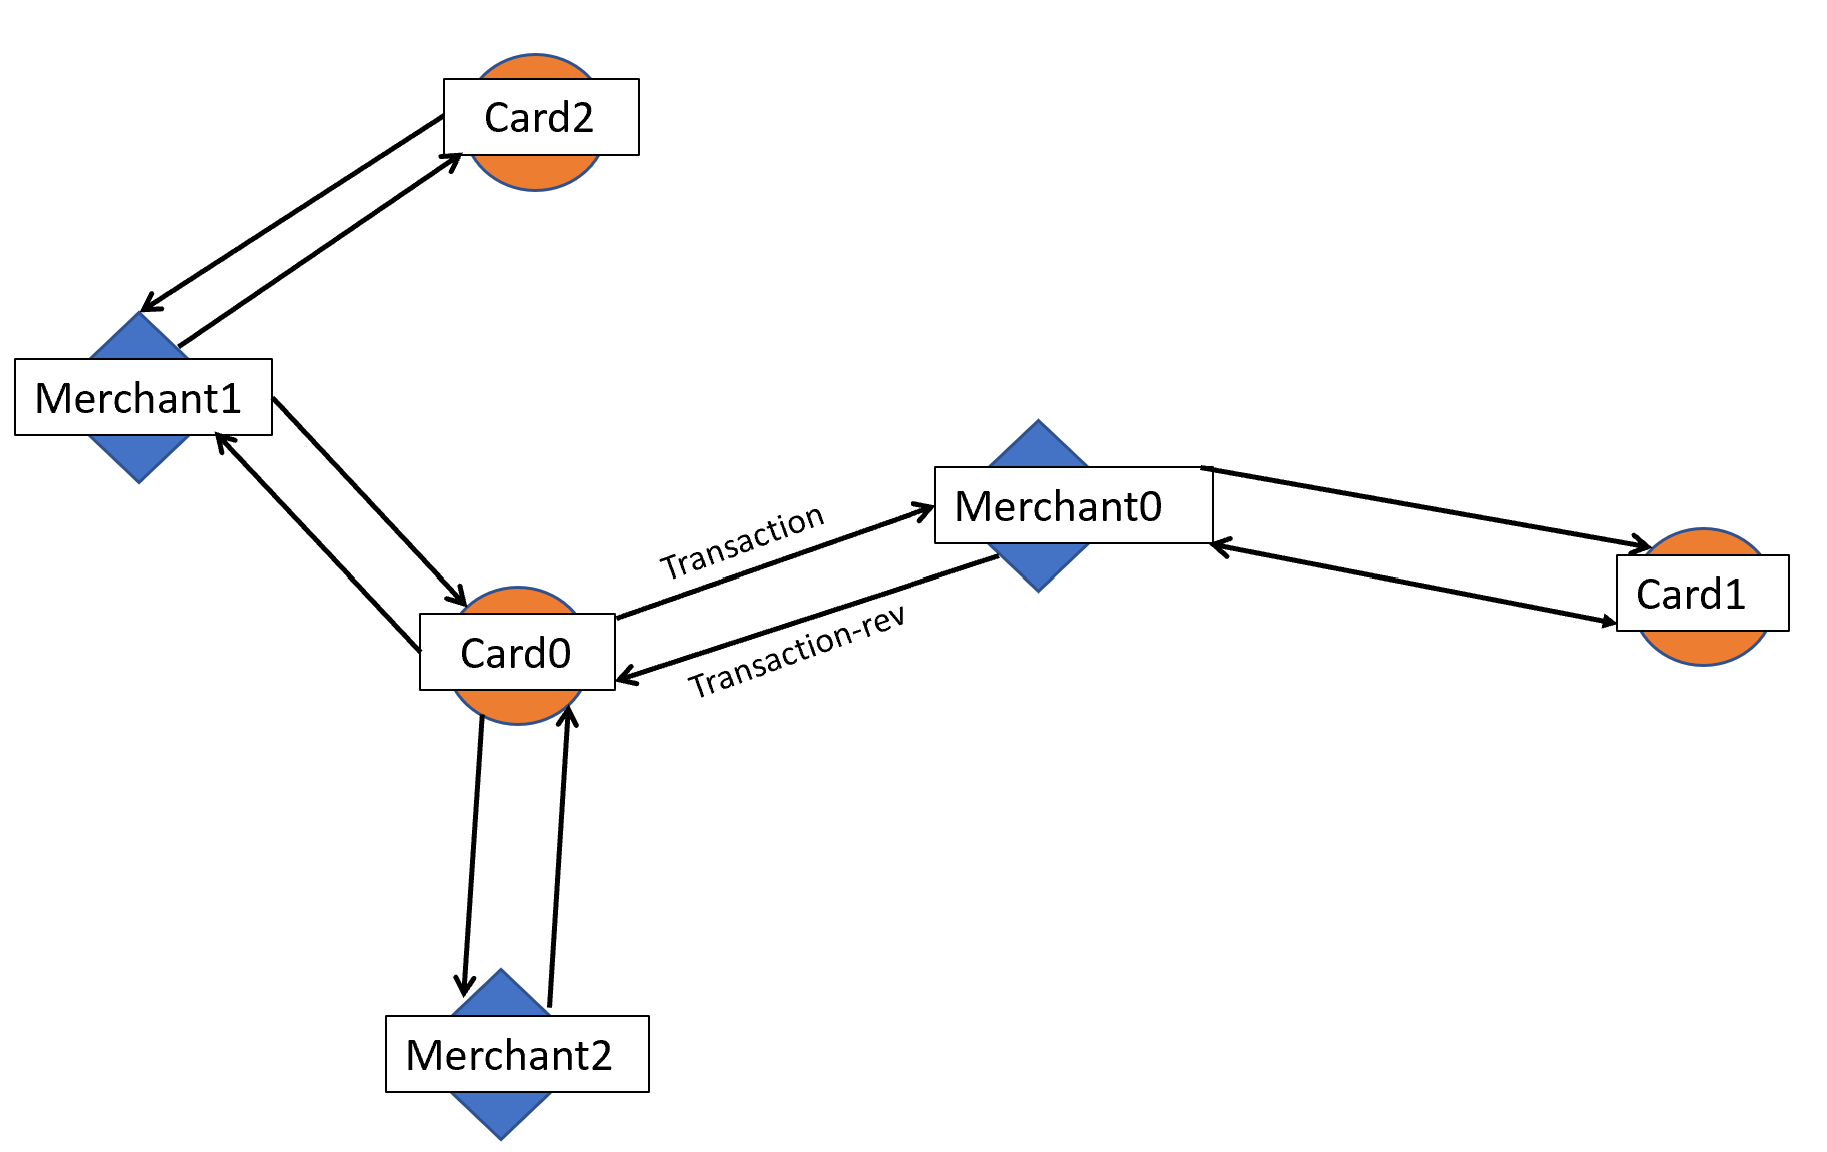

In [1]:
# Standard Libraries
import subprocess
import os
import shutil

import numpy as np
import cudf
import cupy as cp
import torch
from torch.utils.dlpack import from_dlpack

import dgl

import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import torch
from torch.utils.dlpack import from_dlpack
import dgl
from utils import device_mem_size, get_rmm_size

Using backend: pytorch


We will perform all our I/O in a specified base directory.

In [2]:
BASE_DIR = "./basedir"

In [3]:
# Ensure BASE_DIR exists
if not os.path.isdir(BASE_DIR):
    os.mkdir(BASE_DIR)

## Download Data

Please download the dataset from this [link](https://github.com/IBM/TabFormer/tree/main/data/credit_card), extract it and place in the folder called `data` inside the `BASE_DIR`

In [4]:
# CHANGE ME
DATA_DIR = 'data'

In [5]:
data_path = os.path.join(BASE_DIR, DATA_DIR)

In [6]:
# Define and clean our processed data
processed_path = os.path.join(BASE_DIR, "processed_data_1gpu")

## Data Preprocessing

In [7]:
gdf = cudf.read_csv(os.path.join(data_path, 'card_transaction.v1.csv'))

We start by cleaning up the column names and creating a `card_id` column by appending `card` number to `user` id.

In [8]:
# rename to lowercase and replace whitespace with underscore
gdf.columns = [i.lower().replace(" ", "_") for i in gdf.columns.tolist()]
gdf = gdf.rename(columns={'is_fraud?' : 'is_fraud', 'errors?' : 'errors'})
gdf['card_id'] = gdf['user'].astype('str') + gdf['card'].astype('str')

Note: Merchant name are hashed strings which is why we see long integers. 

Merchant name can be thought of as merchant_id for our purproses so we rename it to `merchant_id`

In [9]:
# rename merchant_name to merchant_id
gdf = gdf.rename(columns={'merchant_name': 'merchant_id'})
# convert card_id and merchant_id to int dtypes
gdf['card_id'] = gdf['card_id'].astype(int)
gdf['merchant_id'] = gdf['merchant_id'].astype(int)

## Train Test Split

Our transactions data spans Jan 1991 to Feb 2020. We set years 1990-2017 as training data,  2018-2020 as test data. This corresponds to roughly 85% train and 15% test split.

In [10]:
gdf['is_train'] = (gdf.year < 2018)

In [11]:
train_card_id = gdf.loc[gdf['is_train'], 'card_id']
test_card_id = gdf.loc[~gdf['is_train'], 'card_id']

In [12]:
train_merch_id = gdf.loc[gdf['is_train'], 'merchant_id']
test_merch_id = gdf.loc[~gdf['is_train'], 'merchant_id']

We see that we have around 4,782 unique credit cards in training set and 5,264 unique cards in test set. So around 482 cards are only present in test but not training set. 

In [13]:
train_card_id.nunique()

4782

In [14]:
test_card_id.nunique()

5264

Since we don't really have card node features (i.e. our credit cards don't have associated attributes like credit score, etc) and merchant node features in the Tabformer dataset we will be forced to do transductive Link Prediction. That is we need to ensure we have the same set of cards and merchants in both training and test because our GNN (even if we use inductive model like GraphSage) will not be able to produce embeddings for new unseen cards and merchants at test time in the absence of actual node features. And so we go ahead and remove cards and merchants that are only present in test set but not in training set.

**NOTE:** If we had node features for cards and merchants then our GNN could have perhaps generalized to new unseen cards and merchants so absence of proper features for card and merchants that can be used as node features is a big limitation of the TabFormer dataset.

In [15]:
gdf_card_id = gdf['card_id']
train_cards = train_card_id.unique()
only_cards_in_train_and_test = gdf_card_id.isin(train_cards)
gdf = gdf[only_cards_in_train_and_test]

In [16]:
gdf_merch_id = gdf['merchant_id']
train_merchs = train_merch_id.unique()
only_merchs_in_train_and_test = gdf_merch_id.isin(train_merchs)
gdf = gdf[only_merchs_in_train_and_test]

### Renumbering node ids for DGL

In the graph we will build cards and merchants will be nodes with the `card_id` and `merchant_id` acting as the node ids. Since DGL requires the node ids to be renumbered in the range `0,1,2,,,N-1` where `N` is the total number of nodes we will have to renumber our `card_ids` to map them to to `0,1,2,..,N-1` through cuDF's `factorize()` (just like in Pandas). We will do the same thing for `merchant_id`.

In [17]:
gdf['card_id'], uniq_card_id = gdf['card_id'].factorize()

In [18]:
uniq_card_id = uniq_card_id.to_frame(name='card_id').reset_index(drop=True)

In [19]:
gdf['merchant_id'], uniq_merch_id = gdf['merchant_id'].factorize()

In [20]:
uniq_merch_id = uniq_merch_id.to_frame(name='merchant_id').reset_index(drop=True)

In [21]:
train_mask = gdf['is_train']

In [22]:
test_mask = ~gdf['is_train']

In [23]:
card_nodes = gdf['card_id'].astype('int64')
merch_nodes = gdf['merchant_id'].astype('int64')

## About DGL Heterograph

DGL's Heterograph supports creating the graph both on the CPU or GPU. Since very large scale graphs may not be able to fit in single GPU memory we may have to create the Heterograph in CPU memory. The Heterograph function also requires the data to be in Pytorch tensors so first we will need to convert `card_nodes`, `merchant_nodes`, to Pytorch tensors. If your processed dataframes can fit on GPU memory you can convert them to Pytorch Tensors on the GPU in a zero-copy fashion through [DLPack](https://github.com/dmlc/dlpack). Otherwise you can use Dask Pandas and Numpy to convert to Pytorch Tensors in CPU memory.

Now we are ready to create the graph structure using [`dgl.heterograph`](https://docs.dgl.ai/en/v0.7.0/generated/dgl.heterograph.html). It requires the `data_dict` which is the data dictionary for constructing a heterogeneous graph. The keys in the dictionary are in the form of string triplets `(src_type, edge_type, dst_type)`, specifying the source node, edge, and destination node types. The values are in the form `(U,V)`, where `U` and `V` are 1D tensors and `(U[i],V[i])` forms the edge with ID `i`.  So we will be able to create our heterograph by passing in this “tuple of node-tensors”

By default, every edge in DGL is directed so if we want both cardholder and merchants to have message passing between each other we need to add a reverse edge `transaction-rev` in addition to the `transaction` edge.

In [24]:
# convert to tensor and move tensor to cpu 
# since we are creating dgl heterograph in CPU
card_nodes_tensor = from_dlpack(card_nodes.to_dlpack()).to('cpu')

In [25]:
merch_nodes_tensor = from_dlpack(merch_nodes.to_dlpack()).to('cpu')

In [26]:
data_dict = {('card',  'transaction', 'merchant') : (card_nodes_tensor, merch_nodes_tensor),
            ('merchant', 'transaction-rev', 'card') : (merch_nodes_tensor, card_nodes_tensor)}

In [27]:
g = dgl.heterograph(data_dict)

In [28]:
# convert masks to tensors
train_mask = from_dlpack(train_mask.to_dlpack()).to('cpu')
test_mask = from_dlpack(test_mask.to_dlpack()).to('cpu')

In [29]:
g.edata['train_mask'] = {('card', 'transaction', 'merchant') : train_mask}
g.edata['test_mask'] =  {('card', 'transaction', 'merchant') : test_mask}

In [30]:
g

Graph(num_nodes={'card': 4782, 'merchant': 93298},
      num_edges={('card', 'transaction', 'merchant'): 24198836, ('merchant', 'transaction-rev', 'card'): 24198836},
      metagraph=[('card', 'merchant', 'transaction'), ('merchant', 'card', 'transaction-rev')])

## Save Graph and Data

We will use the `save_graphs` function in DGL to save the heteograph in binary format for later use. 

In [31]:
dgl.save_graphs(os.path.join(processed_path, "transaction_graph.bin"), [g])

Let's also save the `card_id` and `merchant_id` mapping as that will be useful later.

In [32]:
uniq_card_id.to_parquet(os.path.join(processed_path, 'uniq_card_id.parquet'))

In [33]:
uniq_merch_id.to_parquet(os.path.join(processed_path, 'uniq_merch_id.parquet'))

Finally we save the processed transactions dataset.

In [34]:
gdf.to_parquet(os.path.join(processed_path, 'subset_transactions.parquet'))